# MLP-CW3 NN Baseline Training Framework 


## Imports

In [1]:
# set the matplotlib backend so figures can be saved in the background
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import matplotlib
import keras
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2

import shutil
import fnmatch
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.constraints import max_norm
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
import keras.initializers
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import keras.optimizers
from keras.utils import np_utils
from keras import backend as K
from sklearn.metrics import confusion_matrix
import seaborn as sns

Using TensorFlow backend.


## File Processings

In [2]:

run_this = 0

##########################################
def gen_find(filepat,top):
    for path, dirlist, filelist in os.walk(top):
        for name in fnmatch.filter(filelist,filepat):
            yield os.path.join(path,name)
            
if run_this == 1:
    #Benign
    src = '../data/benign/SOB/' # input
    dst = '../Benign/' # desired location

    filesToMove = gen_find("*png",src)
    for name in filesToMove:
        shutil.copy(name, dst)
    
    #Malignant
    src = '../data/malignant/SOB/' # input
    dst = '../Malignant/' # desired location

    filesToMove = gen_find("*png",src)
    for name in filesToMove:
        shutil.copy(name, dst)

## Environment Settings

In [3]:
#Keras setting
K.set_image_dim_ordering('tf')  #Image dimension ordering


#Random seeds
SEED = 2082018
np.random.seed(SEED)

#Image Settings
IMAGE_RESIZE = (224,224)  # Image size. Process on the by data generator. Should match CNN model input. 

#Training Settings
BATCH_SIZE = 1
EPOCH = 20

#Directories
# NOTE: The labels are determined by subfolders. PNG or JPEG images only.
TRAIN_DIR = '../../TRAIN' 
VAL_DIR = '../../VALID'
TEST_DIR =  '../../VALID'

#Model Settting
CLASSIFICATION_MODE = 'binary'  # use 'categorical' for multi-class. 


#Checkpoints and save files

# Saving every epochs that improve val accuracy
 #MODEL_CHECKPOINT_FILE="baseline_model-weights-{epoch:02d}-{val_acc:.2f}.hdf5"
# Rewriting save file for epoch that improves val accuracy
MODEL_CHECKPOINT_FILE="baseline_model-weights.hdf5"  

#Training charts and graphics
MODEL_TRAIN_RESULTS_FILE="baseline_train.pickle"
MODEL_ACCURACY_GRAPH_FILE="baseline_accuracy.pdf"
MODEL_LOSS_GRAPH_FILE="baseline_loss.pdf"


## Data Augmentation

See Keras documentation for details https://faroit.github.io/keras-docs/1.1.0/preprocessing/image/


In [4]:
#No augmentation on baseline. Only normalize to [0,1.0] scale.
trainDataGenerator = ImageDataGenerator(rescale=1./255)
validationDataGenerator = ImageDataGenerator(rescale=1./255)
testDataGenerator = ImageDataGenerator(rescale=1./255)

## Building Data Generator

In [5]:
# Building Data Generator
trainDataGenerator = trainDataGenerator.flow_from_directory(
        TRAIN_DIR,
        target_size=IMAGE_RESIZE,
        batch_size=BATCH_SIZE,
        #color_mode='grayscale',
        class_mode=CLASSIFICATION_MODE)

validationDataGenerator = validationDataGenerator.flow_from_directory(
        VAL_DIR,
        target_size=IMAGE_RESIZE,
        batch_size=BATCH_SIZE,
        #color_mode='grayscale',
        class_mode=CLASSIFICATION_MODE)

testDataGenerator = testDataGenerator.flow_from_directory(
        VAL_DIR,
        target_size=IMAGE_RESIZE,
        batch_size=BATCH_SIZE,
        #color_mode='grayscale',
        class_mode=CLASSIFICATION_MODE)


Found 5252 images belonging to 2 classes.
Found 1735 images belonging to 2 classes.
Found 1735 images belonging to 2 classes.


# Building Neural Net Model

In [6]:
# Building Models
def baseline_model():
    weight_init = keras.initializers.glorot_uniform(seed=SEED)
    sgd = keras.optimizers.SGD(lr=0.01, decay=0, momentum=0.0)
    adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.0)
    model = Sequential()
    model.add(Dropout(0.2, seed=SEED,input_shape=(28, 28,1)))
    model.add(Conv2D(32, (3, 3)))#, input_shape=(28, 28,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2) ))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))         
    #Classification Layers
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01)) 
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

def LeNet():
    adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.0)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     input_shape=(224, 224,3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01)) 
    model.add(MaxPooling2D(pool_size=(2, 2) ))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01)) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01)) 
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

model = LeNet()

#### Setting checkpoint options

In [7]:
checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILE, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#### Loading weights

In case issue with training / crash. Run this to load the weights into model. You can either train the model or use it for classification.


In [8]:
run_this = 1

#Specify checkpoint file here
CHECKPOINT_FILE = MODEL_CHECKPOINT_FILE

###############################################
if run_this == 1:
    model.load_weights(CHECKPOINT_FILE)

# Training

In [9]:
run_this = 1

if run_this == 1:
    
    #Train models
    history = model.fit_generator(
        trainDataGenerator,
        epochs = EPOCH,
        steps_per_epoch = len(trainDataGenerator),
        validation_data = validationDataGenerator,
        validation_steps = len(validationDataGenerator),
        callbacks = callbacks_list)
    
    #Saving training result
    with open(MODEL_TRAIN_RESULTS_FILE, "wb") as output_file:
        pickle.dump(history.history, output_file)

Epoch 1/20
5252/5252 [==============================] - 353s 67ms/step - loss: 0.6005 - acc: 0.7119 - val_loss: 8.1302 - val_acc: 0.3890
Epoch 2/20
5252/5252 [==============================] - 356s 68ms/step - loss: 0.6005 - acc: 0.7119 - val_loss: 8.3666 - val_acc: 0.3816
Epoch 3/20
5252/5252 [==============================] - 360s 68ms/step - loss: 0.6004 - acc: 0.7119 - val_loss: 8.2595 - val_acc: 0.3931
Epoch 4/20
5252/5252 [==============================] - 357s 68ms/step - loss: 0.6005 - acc: 0.7119 - val_loss: 8.1976 - val_acc: 0.3867
Epoch 5/20
5252/5252 [==============================] - 352s 67ms/step - loss: 0.6004 - acc: 0.7119 - val_loss: 8.2523 - val_acc: 0.3908
Epoch 6/20
5252/5252 [==============================] - 356s 68ms/step - loss: 0.6004 - acc: 0.7119 - val_loss: 8.0392 - val_acc: 0.3948
Epoch 7/20
5252/5252 [==============================] - 355s 68ms/step - loss: 0.6004 - acc: 0.7119 - val_loss: 8.2815 - val_acc: 0.3890
Epoch 8/20
5252/5252 [===================

#### Visualizing Training

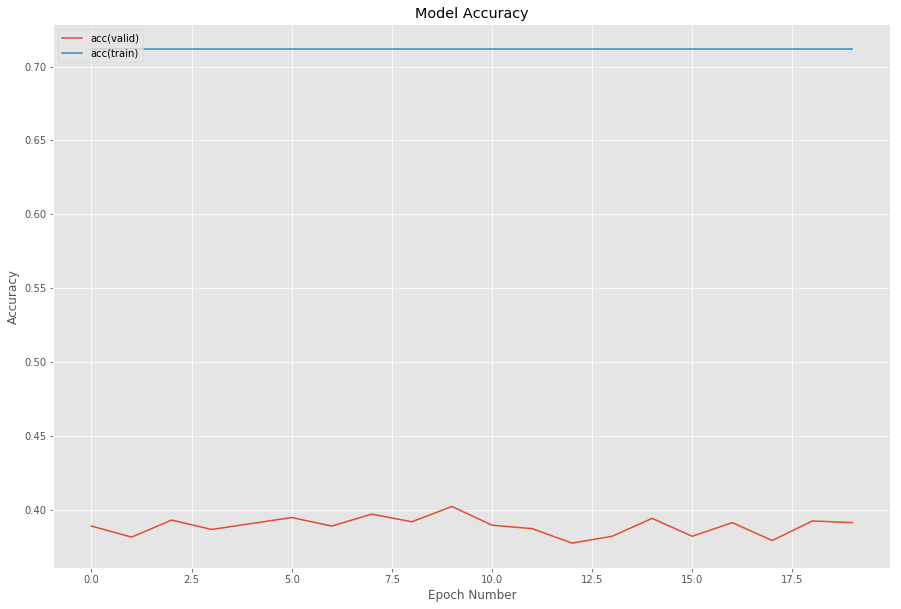

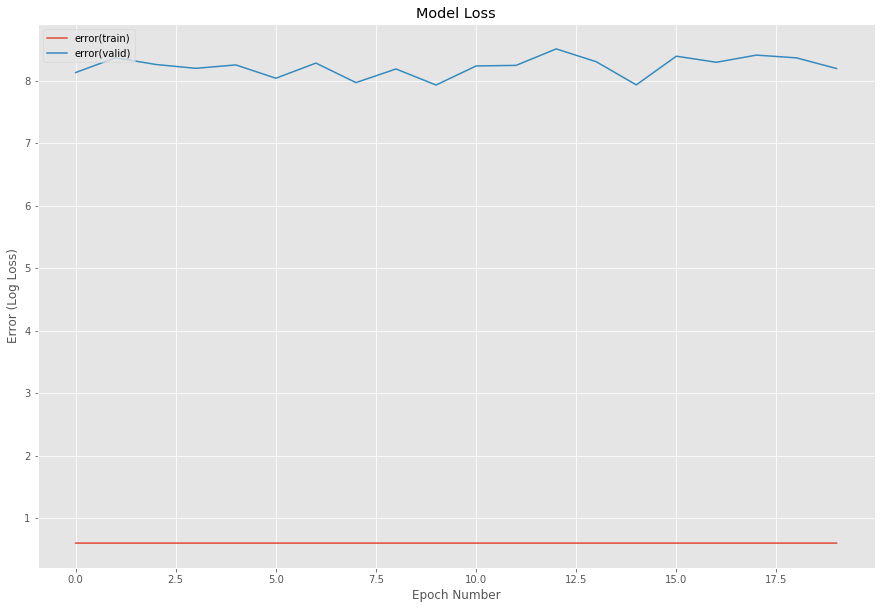

Val Acc:  0.402305475504
Train Acc:  0.71191926885
Val Err:  8.50846312689
Train Err:  0.60046547817


In [13]:
run_this = 1

if run_this == 1:
    with open(MODEL_TRAIN_RESULTS_FILE, "rb") as input_file:
        history = pickle.load(input_file)
    plt.style.use('ggplot')
    accuracy_plot = plt.figure(figsize=(15,10))
    for k in ['val_acc', 'acc']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch Number')
    plt.legend(['acc(valid)', 'acc(train)'], loc='upper left')
    plt.grid(True)
    plt.show()
    loss_plot = plt.figure(figsize=(15,10))
    for k in ['loss', 'val_loss']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Loss')
    plt.ylabel('Error (Log Loss)')
    plt.xlabel('Epoch Number')
    plt.grid(True)
    plt.legend(['error(train)', 'error(valid)'], loc='upper left')
    plt.show()
    #Save visualization data
    print("Val Acc: ",np.max(np.array(history['val_acc'])))
    print("Train Acc: ", np.max(np.array(history['acc'])))
    print("Val Err: ",np.max(np.array(history['val_loss'])))
    print("Train Err: ", np.max(np.array(history['loss'])))
    accuracy_plot.savefig(MODEL_ACCURACY_GRAPH_FILE, bbox_inches='tight')
    loss_plot.savefig(MODEL_LOSS_GRAPH_FILE, bbox_inches='tight')

# Evaluation

## Validation Set Confusion Matrix

#### Note: 
The labels are hard coded and might not represent the actual label as automatically created by DataGenerator. So switch it around until we figure out the solution

In [11]:
run_this = 0

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    plot = plt.figure()
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return plot
    
    
if run_this == 1:
    
    #Load Validation Data
    imagePaths = sorted(list(paths.list_images(VAL_DIR)))
    data = []
    labels = []
    for imagePath in imagePaths:
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        data.append(image)
     
        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]
        label = 1 if label == "Benign" else 0
        labels.append(label)
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    y_pred = model.predict(data)
    #Make prediction
    
    #Display confusion matrix
    
    cm = confusion_matrix(labels, np.rint(y_pred))
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plot = plot_confusion_matrix(cm_norm, classes=["Benign", "Malignant"])
    plot.savefig("CM.pdf", bbox_inches='tight')

## Test Data
Scalar test loss (if the model has no metrics) or list of scalars (if the model computes other metrics). The attribute model.metrics_names will give you the display labels for the scalar outputs.

In [12]:
run_this = 0

if run_this == 1:
    scores = model.evaluate_generator(testDataGenerator,steps=len(testDataGenerator)) 
    print(scores)
    print(model.metrics_names)
    